# Overview

This notebook contains all code and discussions for the __intermediate iteration__ of the research question involving __lesion diagnosis/type and malignancy__. The specific question asked is whether there are statistically significant differences between the malignancy rates of different types of lesion diagnoses. This is an advanced version of [this novice module](../novice/Q3.ipynb) revolving around the same features.

# Table of Contents

I. [Setup](#setup)

II. [Data Retrieval](#dr)

1. [File Access](#fa)
2. [Loading & Processing](#lp)

III. [Analysis](#anl)

1. [Experimental Design](#ed)
2. [Testing](#t)

IV. [Discussion](#d)

# Setup <a id='setup'></a>

Refer to [this module](../novice/Data_Download.ipynb) for replicating the data-download process using the ISIC Python tool. The command is repeated below, although file/directory locations may need adjustment. 

`
python download_archive.py \
--num-images=50 \ 
--images-dir ../../sample_imgs \ 
--descs-dir ../../sample_dscs -s \ 
--seg-dir ../../sample_segs --seg-skill expert
`

The following are necessary imports for this module.

In [84]:
# data retrieval
import glob
import json

# data manipulation, analysis, and visualization
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Data Retrieval <a id='dr'></a>

# File Access <a id='fa'></a>

Note that image manipulation is not actually needed for this module. This shortens data retrieval; the same `glob.glob` functionality as before can be used, to get an array of paths for description files only.

In [35]:
dsc_filepaths = glob.glob('../../dscs/*')
print('Descriptions: ', len(dsc_filepaths))

Descriptions:  69445


# Loading & Processing <a id='lp'></a>

Descriptions are stored in JSON format as before. Opening a single file is useful for determining the attributes of interest. Here, the attributes `benign_malignant` and `diagnosis` (nested in the `clinical` attribute of the `meta` key) are direct representations of the features in question above.

In [36]:
json.load(open(dsc_filepaths[0], 'r'))

{'_id': '5436e3abbae478396759f0cf',
 '_modelType': 'image',
 'created': '2014-10-09T19:36:11.989000+00:00',
 'creator': {'_id': '5450e996bae47865794e4d0d', 'name': 'User 6VSN'},
 'dataset': {'_accessLevel': 0,
  '_id': '5a2ecc5e1165975c945942a2',
  'description': 'Moles and melanomas.\nBiopsy-confirmed melanocytic lesions. Both malignant and benign lesions are included.',
  'license': 'CC-0',
  'name': 'UDA-1',
  'updated': '2014-11-10T02:39:56.492000+00:00'},
 'meta': {'acquisition': {'image_type': 'dermoscopic',
   'pixelsX': 1022,
   'pixelsY': 767},
  'clinical': {'age_approx': 55,
   'anatom_site_general': 'anterior torso',
   'benign_malignant': 'benign',
   'diagnosis': 'nevus',
   'diagnosis_confirm_type': None,
   'melanocytic': True,
   'sex': 'female'}},
 'name': 'ISIC_0000000',
 'notes': {'reviewed': {'accepted': True,
   'time': '2014-11-10T02:39:56.492000+00:00',
   'userId': '5436c6e7bae4780a676c8f93'},
  'tags': ['Challenge 2018: Task 1-2: Training',
   'Challenge 2019:

Each data point can hence be thought of as a (malignancy, diagnosis type) pair or tuple. We can iterate over all filepaths, extract the two variable values, and format them this way, as follows.

In [52]:
# first load descriptions, and extract clinical variables
dscs = []
for i in range(len(dsc_filepaths)):
    data = json.load(open(dsc_filepaths[i], 'r'))['meta']['clinical']
    try:
        data = (data['benign_malignant'], data['diagnosis'])
        dscs.append(data)
    except KeyError:
        continue
    if i % 10000 == 0 or i==len(dsc_filepaths)-1:
        print('Just finished loading point %d' % (i+1))

# sample output
for i in range(3):
    print('Data point #%d: %s' % (i, dscs[i]))

Just finished loading point 1
Just finished loading point 10001
Just finished loading point 20001
Just finished loading point 30001
Just finished loading point 40001
Just finished loading point 50001
Just finished loading point 60001
Just finished loading point 69445
Data point #0: ('benign', 'nevus')
Data point #1: ('benign', 'nevus')
Data point #2: ('malignant', 'melanoma')


For analysis this is best stored as a `pandas.DataFrame` table, which can be done easily. 

In [54]:
df = pd.DataFrame(dscs, columns=['malignancy', 'diagnosis'])
df.head()

,malignancy,diagnosis
0,benign,nevus
1,benign,nevus
2,malignant,melanoma
3,benign,nevus
4,malignant,melanoma


# Analysis <a id='anl'></a>

## Experimental Design <a id='ed'></a>

For the integrity of later tests, it is necessary to recognize the shape of the data. The split between benign/malignant labels in the table is extreme, which may influence analyses. Also remove the irrelevant benign/malignant flags.

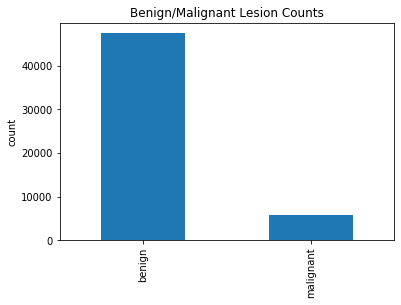

In [57]:
df = df[(df.malignancy == 'benign') | (df.malignancy == 'malignant')]
df.malignancy.value_counts().plot(kind='bar', title='Benign/Malignant Lesion Counts')
plt.ylabel('count')
plt.show()

Even more important is the split between the different lesion diagnoses in the table, since too much of a skew may cause issues with statistical assumptions.

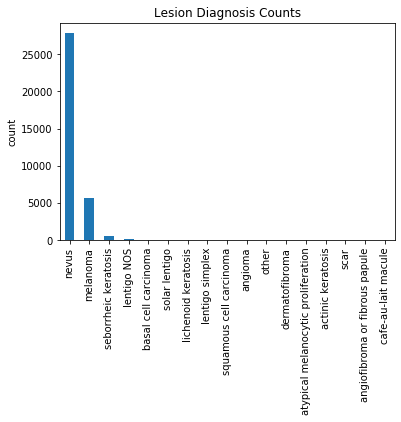

In [58]:
df.diagnosis.value_counts().plot(kind='bar', title='Lesion Diagnosis Counts')
plt.ylabel('count')
plt.show()

The following issues emerge:

1. There is an 'unknown' category whose size eclipses most other diagnoses, but without any additional clinical/background information. 
2. Given the categorical variables, it cannot be determined that the data approximates a Gaussian distribution. There are many categories, and a statistical test is needed to compare all of them to determine any significant differences in maligant lesion occurrence. 
3. Some categories are sparsely populated (with only tens or single-digit amounts of samples, compared to the hundreds/thousands of others).

To which the following reasoning can be applied:

1. 'Unknown' could be referring to a diagnosis that is not yet known, or a diagnosis that is known but could not be accurately identified by the personnel or equipment available. So, it is better to exclude it, rather than compare it with other groups without any clarification as to its nature.

In [60]:
# standardize all string values
df.malignancy = df.malignancy.apply(lambda x: str(x).lower())
df.diagnosis = df.diagnosis.apply(lambda x: str(x).lower())
print('N:', len(df))

# drop unknown diagnoses
df = df[df.diagnosis != 'unknown']
print('N (after dropping):', len(df))

N: 53231
N (after dropping): 53231


2. The members of each group are independent, so no paired test is appropriate. There is 1 independent variable (diagnosis) with more than 2 groups, and a non-ranked outcome. Given the absent normality assumption, the Chi-Square Test of Independence is most appropriate. 
3. Chi-Square tests demand minimum expected counts for each group: no group can have expected value < 0, and at most 20% of groups can have expected value < 5. To calculate expected values, first construct a contingency table.

In [61]:
df_crosstab = pd.crosstab(df.diagnosis, df.malignancy)
df_crosstab

malignancy,benign,malignant
diagnosis,,
actinic keratosis,2,0
angiofibroma or fibrous papule,1,0
angioma,15,0
atypical melanocytic proliferation,3,0
basal cell carcinoma,1,67
cafe-au-lait macule,1,0
dermatofibroma,7,0
lentigo nos,111,0
lentigo simplex,27,0


The expected value for each cell is `row_total * column_total / grand_total`. These can be determined for each diagnosis. First restructure the contingency table.

In [63]:
# flatten contingency table so each diagnosis 'row' has benign/malignant counts
df_contingency = df_crosstab.rename_axis(None, axis=1).reset_index()
df_contingency

,diagnosis,benign,malignant
0,actinic keratosis,2,0
1,angiofibroma or fibrous papule,1,0
2,angioma,15,0
3,atypical melanocytic proliferation,3,0
4,basal cell carcinoma,1,67
5,cafe-au-lait macule,1,0
6,dermatofibroma,7,0
7,lentigo nos,111,0
8,lentigo simplex,27,0
9,lichenoid keratosis,32,0


Store grand and column totals and assert they line up with initial data.

In [64]:
grand_total = len(df)
total_b = df_contingency.benign.sum()
total_m = df_contingency.malignant.sum()

print('Benign: %d, Malignant: %d' % (total_b, total_m))
df.malignancy.value_counts()

Benign: 47526, Malignant: 5705


benign       47526
malignant     5705
Name: malignancy, dtype: int64

Create row totals for ease.

In [66]:
df_contingency['row_total'] = df_contingency.benign + df_contingency.malignant
df_contingency

,diagnosis,benign,malignant,row_total
0,actinic keratosis,2,0,2
1,angiofibroma or fibrous papule,1,0,1
2,angioma,15,0,15
3,atypical melanocytic proliferation,3,0,3
4,basal cell carcinoma,1,67,68
5,cafe-au-lait macule,1,0,1
6,dermatofibroma,7,0,7
7,lentigo nos,111,0,111
8,lentigo simplex,27,0,27
9,lichenoid keratosis,32,0,32


Compute expected values for the entire benign and malignant columns at once, per given formula.

In [67]:
df_exp = df_contingency.copy()
df_exp['expected_benign'] = df_exp.row_total * total_b / grand_total
df_exp['expected_malignant'] = df_exp.row_total * total_m / grand_total
df_exp

,diagnosis,benign,malignant,row_total,expected_benign,expected_malignant
0,actinic keratosis,2,0,2,1.785651,0.214349
1,angiofibroma or fibrous papule,1,0,1,0.892826,0.107174
2,angioma,15,0,15,13.392384,1.607616
3,atypical melanocytic proliferation,3,0,3,2.678477,0.321523
4,basal cell carcinoma,1,67,68,60.712141,7.287859
5,cafe-au-lait macule,1,0,1,0.892826,0.107174
6,dermatofibroma,7,0,7,6.249779,0.750221
7,lentigo nos,111,0,111,99.103643,11.896357
8,lentigo simplex,27,0,27,24.106291,2.893709
9,lichenoid keratosis,32,0,32,28.570419,3.429581


Gather occurrences of <5 expected value in either columns. Observe the droppage that will be needed.

In [73]:
# count cells where <5 condition triggers for either column
occurrences = df_exp[(df_exp.expected_benign<5.0) | (df_exp.expected_malignant<5.0)]
# occurrences = len(occurrences)

# # find and output required droppage
groups = len(df.diagnosis.unique())
invalid_groups = len(occurrences.diagnosis.unique())
limit = int(0.2*groups)
drop = invalid_groups - limit
if limit < invalid_groups:
    print('Limit is %d bad groups, for %d groups, we have %d invalid groups' % (limit, groups, invalid_groups))
    print('Drop worst %d group(s)' % drop)

Limit is 3 bad groups, for 18 groups, we have 11 invalid groups
Drop worst 8 group(s)


Drop by sorting benign/malignant counts as pairusing the row totals. Then drop the first *n* rows.

In [86]:
df_chisq = df_exp.sort_values('row_total').reset_index(drop=True)
df_chisq = df_chisq[8:]
df_chisq = df_chisq[['benign', 'malignant']]
df_chisq

,benign,malignant
8,0,21
9,27,0
10,32,0
11,61,0
12,1,67
13,111,0
14,534,1
15,0,5598
16,18850,18
17,27870,0


## Testing <a id='t'></a>

Perform Chi Square analysis and output results.

In [89]:
chi2, p, dof, exp = chi2_contingency(df_chisq)
print('Statistic is %0.2f and p-value is %0.2f' % (chi2, p))

Statistic is 52982.48 and p-value is 0.00


# Discussion <a id='d'></a>

__*Discuss the findings from the chi-square test for independence.*__

- Was the p-value significant, leading to rejection of the null hypothesis (H0: diagnosis groups are independent)?
- Was the chi-square test appropriate for this data (consider skew, missing values for groups, underlying assumptions)?
- If it __was__ significant, how would the specific relationship/weight of different diagnoses be determined? That is, would further tests reveal which groups have more benign/malignant observations specifically?